
# Get Renewable Ninja Data

1. Extract renewables generation data from Ninja API.
2. Visualize the data?

# Installation
It's recommended to install a conda environment based on the `requirements.txt` file to run this script.
In order to do so, you can run the following command in your terminal: 
```bash
conda create --name reprenv --file requirements.txt
```
If there are some dependencies issues because some package are not included (project is still under construction) in the `requirements.txt` file, install them manually. 

In [2]:
import os
from utils_ninja import *

## User input parameters (to manually change)

User needs to change the following parameters in the following cell:
1. `name_data` : Name of the folder where data will be saved.
2. `extract_renewables` : Whether to extract renewables data from Ninja API or not. If False, the script will use the data file provided by the user. Please note that dowloading data from Ninja API is time consuming, so do it only once. Also, there are API limits on the hourly number of downloads, so it is better to download the data once and use it multiple times.
3. `locations` : Coordinates of the location for which the data is to be extracted. The format is (latitude, longitude).
4. `power_types` : Types of power for which the data is to be extracted. The format is ['solar', 'wind'].
5. `start_year` : Start year of the historical data.
6. `end_year` : End year of the historical data.

You should also update the `API_TOKEN` in `utils.py` by creating an account in Renewable Ninja. This increases the hourly request limit and is required for automated access to the API. See the official Ninja API documentation for more details.

In [5]:
name_data = 'capp' # Name of the zone, used to name the folder where the data is stored

extract_renewables = {'solar': False, 'wind': False} # Set to True to extract data from Renewables Ninja

# If extract_renewables is True, fill the following variables
# Best is to use the same zone name than the one in EPM
# The coordinates can be found thanks to the get_renewables_coordinates.ipynb notebook
locations = {'solar': {'Angola': (-12.4667, 15.7442),
                       'Burundi': (-3.1479, 29.3625),
                       'Cameroon': (9.3271, 13.3621),
                       'CAR': (4.5167, 18.4667),
                       'Chad': (12.0905, 15.1331),
                       'Congo': (1.3863, 16.3364),
                       'DRC': (-1.6414, 29.1938),
                       'Gabon': (0.2293, 9.5315),
                       'EquatorialGuinea': (1.6132, 10.6400),
                       },
             'wind': {'Angola': (-15.2198, 12.7258),
                      'Cameroon': (4.8918, 12.3598),
                      'Chad': (12.1232, 15.0712)}}


start_year = 2023 # earliest year is 1980
end_year = 2024


## Create the folder structure


In [6]:
folder_input = 'input'
# Make folder
if not os.path.exists(folder_input):
    os.makedirs(folder_input)
    
folder_output = 'output'
if not os.path.exists(folder_output):
    os.makedirs(folder_output)

power_types = list(locations.keys()) # 'wind' or 'solar'

print(f'Extracting data from {start_year} to {end_year} for {name_data}')

Extracting data from 2023 to 2024 for capp


## 1. Extract data from Renewables Ninja

Depends on the `extract_renewables` parameter, the script will extract the data from the Ninja API or use the data file provided by the user.

In [7]:
for power_type in power_types:
    print('Processing power type {}'.format(power_type))
    if extract_renewables[power_type]:
        locations_power = locations[power_type]
        get_years_renewables(locations=locations_power, power_type=power_type,
                             start_year=start_year, end_year=end_year,
                             name_data=name_data, output=folder_input,
                             local_time=True)

Processing power type solar
Processing power type wind


## 2. Explore and format data

In [10]:
filenames = {'PV': os.path.join(folder_input, 'data_{}_solar.csv'.format(name_data)),
             'Wind': os.path.join(folder_input, 'data_{}_wind.csv'.format(name_data)),
             }

df_energy = {}
for tech, filename in filenames.items():
    if os.path.exists(filename):
        print(f'Loading data from {filename}')
        df_energy[tech] = pd.read_csv(filename, index_col=None, header=[0])
    else:
        print(f'File {filename} does not exist. Please check the input folder.')

# Make heatmaps and boxplots to explore the data
for tech, df in df_energy.items():
    make_heatmap(df, tech=tech, path=os.path.join(folder_output, f'heatmap_{tech}_{name_data}.png'))
    make_boxplot(df, tech=tech, path=os.path.join(folder_output, f'boxplot_{tech}_{name_data}.png'))

Loading data from input/data_capp_solar.csv
Loading data from input/data_capp_wind.csv


ValueError: could not convert string to float: '1 - 1'

<Figure size 1200x600 with 0 Axes>

In [13]:
tmp

,season,day,2023,season-day
0,1,1,0.158782,1 - 1
1,1,2,0.167537,1 - 2
2,1,3,0.155880,1 - 3
3,1,4,0.164903,1 - 4
4,1,5,0.174032,1 - 5
...,...,...,...,...
360,12,27,0.184963,12 - 27
361,12,28,0.195574,12 - 28
362,12,29,0.176116,12 - 29
363,12,30,0.170157,12 - 30


In [16]:
melted

,season,day,zone,daily_mean
0,1,1,2023,0.158782
1,1,2,2023,0.167537
2,1,3,2023,0.15588
3,1,4,2023,0.164903
4,1,5,2023,0.174032
...,...,...,...,...
725,12,27,season-day,12 - 27
726,12,28,season-day,12 - 28
727,12,29,season-day,12 - 29
728,12,30,season-day,12 - 30


ValueError: Unable to parse string "1 - 1" at position 365

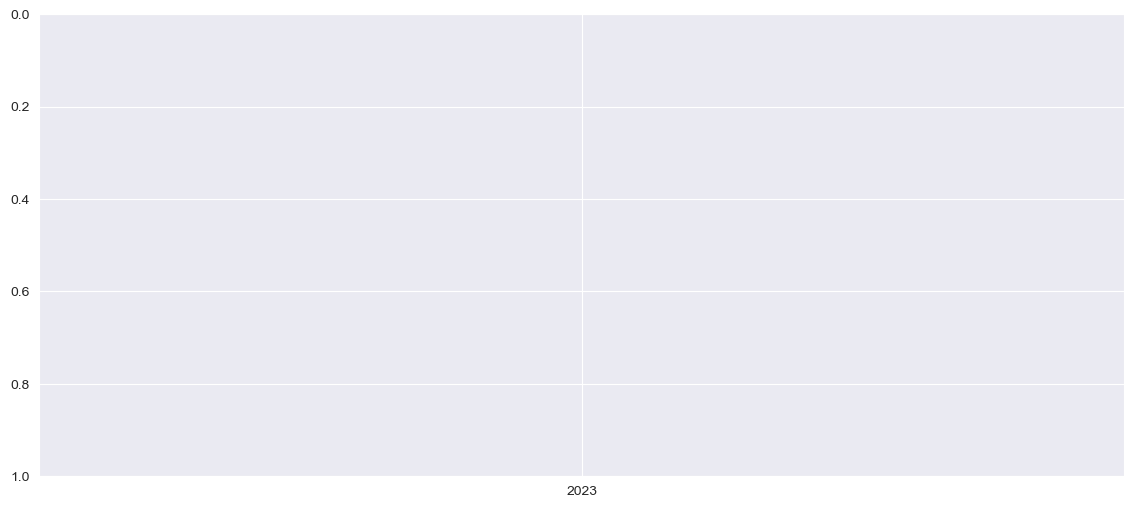

In [12]:
df_energy = df.copy()
#df_energy['season'] = df_energy['season'].apply(lambda x: calendar.month_abbr[int(x)])
daily_df = df_energy.groupby(['season', 'day'], as_index=False).mean(numeric_only=True).drop(columns='hour')
daily_df['season-day'] = daily_df["season"].astype(str) + " - " + daily_df["day"].astype(str)

tmp = daily_df.sort_values(['season', 'day']).copy()

melted = tmp.melt(id_vars=['season', 'day'], value_vars=[col for col in tmp.columns if col not in ['zone', 'season', 'day', 'hour']],
                  var_name='zone', value_name='daily_mean')

plt.figure(figsize=(14, 6))
sns.boxplot(data=melted, x="zone", y="daily_mean", hue="season")
plt.xticks(rotation=45)

plt.legend(
    title='Season',
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    borderaxespad=0.,
    frameon=False
)
plt.ylabel("")
plt.xlabel("")

# Set ymin to 0
plt.ylim(bottom=0)

# Format x-ticks to show only the zone name
xtick_labels = [col.split('_')[1] for col in melted['zone'].unique()]
plt.xticks(range(len(xtick_labels)), xtick_labels, rotation=45)

plt.title(f"Distribution of Daily {tech} Capacity Factor by Season and Zone")
plt.tight_layout()
if path is not None:
    plt.savefig(path, bbox_inches='tight')
    plt.close()
else:
    plt.show()